## 1. 定义算法

### 1.1 定义模型

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256, std = 0):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu_layer = nn.Linear(hidden_dim, output_dim)
        self.sigma =  nn.Parameter(torch.ones(1, output_dim) * std)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mu = torch.tanh(self.mu_layer(x))
        log_std = torch.exp(self.sigma).expand_as(mu)
        return mu,log_std
    
class Critic(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dim=256):
        super(Critic,self).__init__()
        assert output_dim == 1 # critic must output a single value
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

### 1.2 定义经验回放

In [58]:
import random
from collections import deque
class ReplayBufferQue:
    '''经验回放池，使用deque实现'''
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        self.buffer.append(transitions)
    def sample(self, batch_size: int):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        batch = random.sample(self.buffer, batch_size)
        return zip(*batch)
    def clear(self):
        self.buffer.clear()
    def __len__(self):
        return len(self.buffer)

class PGReplay(ReplayBufferQue):
    '''PG的经验回放池，每次采样所有样本，因此只需要继承ReplayBufferQue，重写sample方法即可
    '''
    def __init__(self):
        self.buffer = deque()
    def sample(self, batch_size: int):
        ''' sample all the transitions
        '''
        if len(self.buffer) < batch_size:
            return None
        batch = list(self.buffer)
        return zip(*batch)

### 1.3 定义智能体

In [59]:
import torch
from torch.distributions import Normal
import numpy as np
class Agent:
    def __init__(self,cfg) -> None:
        self.gamma = cfg.gamma
        self.device = torch.device(cfg.device) 
        self.actor = Actor(cfg.state_dim,cfg.action_dim, hidden_dim = cfg.actor_hidden_dim).to(self.device)
        self.critic = Critic(cfg.state_dim,1,hidden_dim=cfg.critic_hidden_dim).to(self.device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=cfg.actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=cfg.critic_lr)
        self.action_space = cfg.action_space
        self.action_scale = (self.action_space.high[0] - self.action_space.low[0])/2
        self.action_bias = (self.action_space.high[0] + self.action_space.low[0])/2
        self.memory = PGReplay()
        self.k_epochs = cfg.k_epochs # update policy for K epochs
        self.eps_clip = cfg.eps_clip # clip parameter for PPO
        self.entropy_coef = cfg.entropy_coef # entropy coefficient
        self.sample_count = 0
        self.batch_size = cfg.batch_size

    def sample_action(self,state):
        self.sample_count += 1
        state = torch.tensor(state, device=self.device, dtype=torch.float32) # [n_envs, state_dim]
        mu, log_std = self.actor(state)
        mean = mu.squeeze(0)*self.action_scale + self.action_bias # [n_envs, 1]
        std = log_std.exp().squeeze(0)
        dist = Normal(mean, std)
        action = dist.sample()
        self.log_probs = dist.log_prob(action).detach()
        print(self.log_probs.shape)
        # action = action * self.action_scale + self.action_bias
        action = action.detach().cpu().numpy()
        return action
    
    @torch.no_grad()
    def predict_action(self,state):
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        mu, log_std = self.actor(state)
        mean = mu.squeeze(0)*self.action_scale + self.action_bias
        std = log_std.exp().squeeze(0)
        dist = Normal(mean, std)
        action = dist.sample()
        self.log_probs = dist.log_prob(action).detach()
        # action = action * self.action_scale + self.action_bias
        action = action.detach().cpu().numpy()
        return action
    
    def update(self):
        # update policy every n steps
        if self.memory.sample(self.batch_size) == None:
            return
        
        old_states, old_actions, old_log_probs, old_rewards, old_dones = self.memory.sample(self.batch_size)
        
        returns = []
        discounted_sum = 0
        for reward, done in zip(reversed(old_rewards), reversed(old_dones)):
            discounted_sum = reward + (self.gamma * discounted_sum * (1 - done))
            # if done:
            #     discounted_sum = 0
            # discounted_sum = reward + (self.gamma * discounted_sum)
            returns.insert(0, discounted_sum)
            
        old_states = [torch.tensor(s, device=self.device, dtype=torch.float32) for s in old_states]
        old_states = torch.cat(old_states)
        old_actions = [torch.tensor(a, device=self.device, dtype=torch.float32) for a in old_actions]
        old_actions = torch.cat(old_actions)
        old_log_probs = [torch.tensor(lp, device=self.device, dtype=torch.float32) for lp in old_log_probs]
        old_log_probs = torch.cat(old_log_probs)
        returns = [torch.tensor(r, device=self.device, dtype=torch.float32) for r in returns]
        returns = torch.cat(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-5) # 1e-5 to avoid division by zero
        returns = returns.unsqueeze(dim=1)
        # convert to tensor
        old_states = torch.tensor(np.array(old_states), device=self.device, dtype=torch.float32)
        old_actions = torch.tensor(np.array(old_actions), device=self.device, dtype=torch.float32)
        old_log_probs = torch.tensor(old_log_probs, device=self.device, dtype=torch.float32).unsqueeze(dim=1)
        old_actions = (old_actions - self.action_bias) / self.action_scale
        # monte carlo estimate of state rewards
        
        # Normalizing the rewards:
        returns = torch.tensor(returns, device=self.device, dtype=torch.float32)
        returns = (returns - returns.mean()) / (returns.std() + 1e-5) # 1e-5 to avoid division by zero
        returns = returns.unsqueeze(dim=1)
        # print(old_states.shape,old_actions.shape,old_log_probs.shape,returns.shape)
        for _ in range(self.k_epochs):
            # compute advantage
            values = self.critic(old_states) # detach to avoid backprop through the critic
            advantage = returns - values.detach()
            # get action probabilities
            mu, log_std = self.actor(old_states)
            dist = Normal(mu.squeeze(1), log_std.squeeze(1))
            # get new action probabilities
            new_log_probs = dist.log_prob(old_actions.squeeze(1)).unsqueeze(dim=1)
            # compute ratio (pi_theta / pi_theta__old):
            ratio = torch.exp(new_log_probs - old_log_probs) # old_log_probs must be detached
            # compute surrogate loss
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantage
            # compute actor loss
            actor_loss = -torch.min(surr1, surr2).mean() + self.entropy_coef * dist.entropy().mean()
            # compute critic loss
            critic_loss = (returns - values).pow(2).mean()
            # take gradient step
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            # avoid gradient explosion
            torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 2)
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 2)
            self.actor_optimizer.step()
            self.critic_optimizer.step()
        self.memory.clear()

## 2. 定义训练

In [60]:
import copy
import gymnasium as gym
from utils.multiprocessing_env import get_eval_reward
def train(cfg, env, agent):
    ''' 训练
    '''
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    test_rewards = []
    steps = []
    best_ep_reward = float('-inf')
    output_agent = None
    state, info = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
    test_env = gym.make(cfg.env_name)
    for frame_idx in range(cfg.max_frames):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.sample_action(state)  # 选择动作
            next_state, reward, terminated, truncated, info = env.step(action)  # 更新环境，返回transition
            agent.memory.push((state, action, agent.log_probs, reward,truncated))  # 保存transition
            state = next_state  # 更新下一个状态
            agent.update()  # 更新智能体
            ep_reward += reward  # 累加奖励
        if (frame_idx+1)%cfg.eval_per_episode == 0:
            test_reward = np.mean([get_eval_reward(test_env=test_env , agent=agent) for _ in range(10)])
            test_rewards.append(test_reward)
            if test_reward >= best_ep_reward:
                best_ep_reward = test_reward
                output_agent = copy.deepcopy(agent)
                print(f"回合：{frame_idx+1}/{cfg.max_frames}，评估奖励：{test_reward:.2f}，最佳评估奖励：{best_ep_reward:.2f}，更新模型！")
            else:
                print(f"回合：{frame_idx+1}/{cfg.max_frames}，评估奖励：{test_reward:.2f}，最佳评估奖励：{best_ep_reward:.2f}")
        steps.append(ep_step)
        rewards.append(ep_reward)
    env.close()
    return output_agent,{'rewards':rewards}

def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for frame_idx in range(cfg.test_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state, info  = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step+=1
            action = agent.predict_action(state)  # 选择动作
            next_state, reward, terminated, truncated, info = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if truncated:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{frame_idx+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards':rewards}

## 3. 定义环境

In [61]:
from utils.multiprocessing_env import create_subproc_vec_env

def env_agent_config(cfg):
    env = create_subproc_vec_env(cfg.env_name, n_envs=cfg.n_envs, seed=cfg.seed)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    print(f"状态空间维度：{state_dim}，动作空间维度：{action_dim}")
    # 更新state_dim和action_dim到cfg参数中
    setattr(cfg, 'state_dim', state_dim)
    setattr(cfg, 'action_dim', action_dim) 
    setattr(cfg, 'action_space', env.action_space) 
    agent = Agent(cfg)
    return env,agent

## 4. 设置参数

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

class Config:
    def __init__(self) -> None:
        self.env_name = "Pendulum-v1" # 环境名字
        self.n_envs = 16
        self.algo_name = "PPO" # 算法名字
        self.mode = "train" # train or test
        self.seed = 1 # 随机种子
        self.device = "cpu" # device to use
        self.max_frames = 1 # 训练的回合数
        self.test_eps = 20 # 测试的回合数
        self.max_steps = 200 # 每个回合的最大步数
        self.eval_eps = 5 # 评估的回合数
        self.eval_per_episode = 10 # 评估的频率
        self.gamma = 0.99 # 折扣因子
        self.k_epochs = 6 # 更新策略网络的次数
        self.actor_lr = 0.0003 # actor网络的学习率
        self.critic_lr = 0.001 # critic网络的学习率
        self.eps_clip = 0.2 # epsilon-clip
        self.entropy_coef = 0.01 # entropy的系数
        self.batch_size = 20 # 更新频率
        self.actor_hidden_dim = 256 # actor网络的隐藏层维度
        self.critic_hidden_dim = 256 # critic网络的隐藏层维度

def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

## 5. 开始训练

状态空间维度：3，动作空间维度：1
开始训练！
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 

/var/folders/_1/zcsnxjr565q683gp6bk05tzh0000gn/T/ipykernel_8672/3886215593.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  old_log_probs = [torch.tensor(lp, device=self.device, dtype=torch.float32) for lp in old_log_probs]
/var/folders/_1/zcsnxjr565q683gp6bk05tzh0000gn/T/ipykernel_8672/3886215593.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  old_log_probs = torch.tensor(old_log_probs, device=self.device, dtype=torch.float32).unsqueeze(dim=1)
/var/folders/_1/zcsnxjr565q683gp6bk05tzh0000gn/T/ipykernel_8672/3886215593.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])


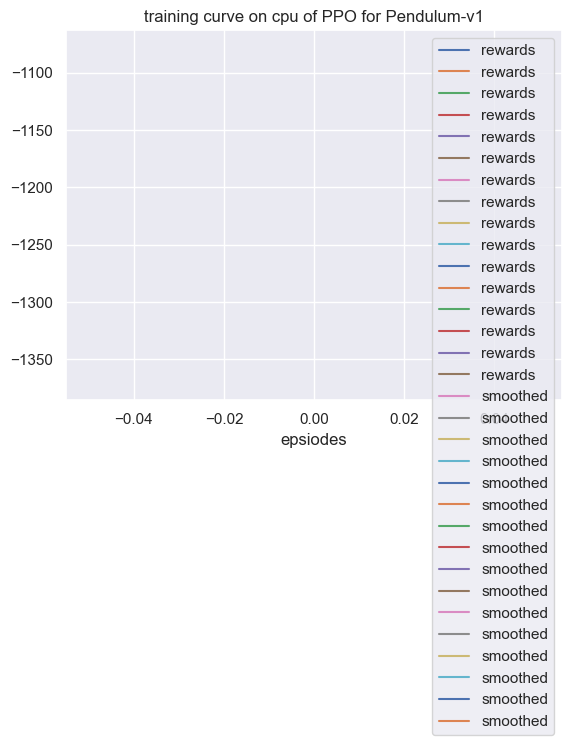

In [63]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
best_agent,res_dic = train(cfg, env, agent)
 
# plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
# res_dic = test(cfg, env, best_agent)
# plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果